# Feature Selection by Filtering Methods

## Initialisation

In [1]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [2]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [3]:
# load in original ccle data
loading_code = 'generic-gdsc-1-FGFR_0939-LN_IC50-fgfr4_ccle_dynamic_features-true-Row'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
feature_data, label_data = data_link.get_data_using_code(loading_code)

In [4]:
from toolkit import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
folder_name = "FeatureSelectionFGFR4"
exp_id = "range1000_nml"
fixed_random_seed = 42 # -1 for no seed
save_figure = True
save_data = True
show_figure = True  

feature_size = feature_data.shape[1]
key_args = {'random_state': fixed_random_seed}

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [6]:
def build_dataframe(selected_indices, scores, feature_data): 
    # if selected_indices are not indices but labels, skip the label conversion step 
    if not isinstance(selected_indices[0], int) and not isinstance(selected_indices[0], np.int64):
        labels = selected_indices
    else:
        labels = feature_data.columns[selected_indices]
    df = pd.DataFrame({'Selected': selected_indices, 'Scores': scores}, index=labels)
    sorted_df = df.sort_values(by='Scores', ascending=False)
    return sorted_df

## Analysis Chain

In [ ]:
rf_selected, rf_score = rf_select(feature_data, label_data, feature_size, **key_args)
rf_select_df = build_dataframe(rf_selected, rf_score, feature_data)

In [ ]:
rf_select_df 

In [ ]:
relieff_selected, relieff_score = relieff_select(feature_data, label_data, feature_size)

In [ ]:
relieff_select_df = build_dataframe(relieff_selected, relieff_score, feature_data)
relieff_select_df

In [ ]:
f_selected, f_score = f_regression_select(feature_data, label_data, feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

In [ ]:
pearson_kwargs = {'return_all': True}
pearson_selected, pearson_score, pearson_pvals = pearson_corr_select(feature_data, label_data, feature_size, **pearson_kwargs)
pearson_df = build_dataframe(pearson_selected, pearson_score, feature_data)
pearson_df

In [ ]:
mutual_selected, mutual_score = mutual_information_select(feature_data, label_data, feature_size)
mutual_df = build_dataframe(mutual_selected, mutual_score, feature_data)
mutual_df

there are two options to ensemble the results of multiple different feature selection results 
1. To propose a universal k-cutoff rank number for all feature selection methods and then union the features 
    e.g. Gather FS Method 1's top 100 features and Gather FS Method 2's top 100 features and union them 
2. To ensemble the rank value of each feature from each method first, and then limit the number of features either using a k-cutoff rank number, or a k-cutoff threshold for the ensemble score. 

## Universal K-Cutoff Rank Method

In [ ]:
k = 50 

def ensemble_k_rank_select(k: int, selection_methods: list, method_kwargs: list, feature_data, label_data):
    all_dfs = []
    assert len(selection_methods) == len(method_kwargs), 'Number of methods and method_kwargs must be equal'
    for idx, method in enumerate(selection_methods):
        selected, score = method(feature_data, label_data, feature_size, **method_kwargs[idx])
        df = build_dataframe(selected, score, feature_data)
        all_dfs.append(df)
    
    all_labels = union_df_labels(k,all_dfs)
    return all_labels

def union_df_labels(k, df_list):
    all_labels = []
    for df in df_list:
        k_best_labels = df.index.tolist()[:k]
        all_labels.extend(k_best_labels)
    
    all_labels = list(set(all_labels))
    return all_labels

In [ ]:
# select_methods = [rf_select, relieff_select, f_regression_select, pearson_corr_select, mutual_information_select]
# method_kwargs = [{'random_state': 42}, {}, {}, {}, {}]
# ensemble_feature_list = ensemble_k_rank_select(k, select_methods, method_kwargs, feature_data, label_data)

df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_labels = union_df_labels(k,df_list)
ensemble_labels

In [ ]:
len(ensemble_labels)

### K-Curve Analysis

based on a k ranging from 0 to n, we can visualise a line plot to the number of ensemble features selected vs the k value

if there is zero overlap, we can expect ensemble features's size to always be k * no. methods 
However, if the overlap is strong, ensemble's feature size should approach k



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style('whitegrid')

max_k = 200
df_list = [rf_select_df, relieff_select_df, f_df, pearson_df, mutual_df]
ensemble_features_length_list = []
k_list = list(range(1, max_k+1))
for k in k_list:
    ensemble_labels = union_df_labels(k,df_list)
    ensemble_features_length_list.append(len(ensemble_labels))


# set plot size 
plt.figure(figsize=(12, 6))
plt.plot(k_list, ensemble_features_length_list, label='Actual')
plt.plot(k_list, k_list, linestyle='--', color='black', label='Low Threshold')
plt.plot(k_list, [k*len(df_list) if k*len(df_list) <= feature_size else feature_size for k in k_list], linestyle='--', color='red', label='High Threshold')
plt.xlabel('K')
plt.ylabel('Number of Features')
plt.title('Overlap K-Curve Analysis for Ensemble Feature Selection')
plt.legend()
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_ensemble_k_curve.png')



## Sungyoung's statistical method 

By generating imputed samples which has shuffled targets. 

In [9]:
random_seeds = list(range(1, 1000))    
shuffled_label_data = [label_data.sample(frac=1, random_state=seed) for seed in random_seeds]

In [10]:
feature_size = feature_data.shape[1]
key_args = {'random_state': 42}

In [11]:
f_selected, f_score = f_regression_select(feature_data, shuffled_label_data[0], feature_size)
f_df = build_dataframe(f_selected, f_score, feature_data)
f_df

invalid value encountered in sqrt


,Selected,Scores
aSos_ttsv,aSos_ttsv,4.314949
aSos_tsv,aSos_tsv,4.178087
aSos_max,aSos_max,3.818385
aSos_auc,aSos_auc,3.420154
aSos_min,aSos_min,3.338916
...,...,...
aCbl_tmin,aCbl_tmin,0.000000
aCbl_tmax,aCbl_tmax,0.000000
PTP_tmin,PTP_tmin,0.000000
aRaf_ttsv,aRaf_ttsv,0.000000


### F-regression

In [7]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
from joblib import Parallel, delayed, cpu_count # type: ignore


def get_shuffled_scores(shuffled_label_data, feature_data, selection_method, method_kwargs, verbose=1, n_jobs=1):
    if n_jobs == -1:
        n_jobs = cpu_count()
    if n_jobs == 1:
        all_scores = []
        for i, label_data in enumerate(shuffled_label_data):
            selected, score = selection_method(feature_data, label_data, feature_size, **method_kwargs)
            all_scores.extend(score)
            if verbose == 1: 
                print(f'Finished {i+1} out of {len(shuffled_label_data)}')
    else: 
        # use joblib to parallelize the process
        def run_one(label_data):
            selected, score = selection_method(feature_data, label_data, feature_size, **method_kwargs)
            return score
        # process shuffled data 20 at a time, so that we can see progress, then concatenate at the end
        divide_n = 20
        if n_jobs > 20:
            divide_n = 40
        shuffled_label_data_chunks = [shuffled_label_data[i:i + divide_n] for i in range(0, len(shuffled_label_data), divide_n)]
        all_scores = []
        for i, chunk in enumerate(shuffled_label_data_chunks):
            scores = Parallel(n_jobs=n_jobs)(delayed(run_one)(label_data) for label_data in chunk)
            all_scores.extend([score for sublist in scores for score in sublist])
            if verbose == 1: 
                print(f'Finished {i+1} out of {len(shuffled_label_data_chunks)} chunks')
                
    return all_scores

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 1 out of 999
Finished 2 out of 999
Finished 3 out of 999
Finished 4 out of 999
Finished 5 out of 999
Finished 6 out of 999
Finished 7 out of 999
Finished 8 out of 999
Finished 9 out of 999
Finished 10 out of 999
Finished 11 out of 999
Finished 12 out of 999
Finished 13 out of 999
Finished 14 out of 999
Finished 15 out of 999
Finished 16 out of 999
Finished 17 out of 999
Finished 18 out of 999
Finished 19 out of 999
Finished 20 out of 999
Finished 21 out of 999
Finished 22 out of 999
Finished 23 out of 999
Finished 24 out of 999
Finished 25 out of 999
Finished 26 out of 999
Finished 27 out of 999
Finished 28 out of 999
Finished 29 out of 999
Finished 30 out of 999
Finished 31 out of 999
Finished 32 out of 999
Finished 33 out of 999
Finished 34 out of 999
Finished 35 out of 999
Finished 36 out of 999
Finished 37 out of 999
Finished 38 out of 999
Finished 39 out of 999
Finished 40 out of 999
Finished 41 out of 999
Finished 42 out of 999
Finished 43 out of 999
Finished 44 out of 9

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 59 out of 999
Finished 60 out of 999
Finished 61 out of 999
Finished 62 out of 999
Finished 63 out of 999
Finished 64 out of 999
Finished 65 out of 999
Finished 66 out of 999
Finished 67 out of 999
Finished 68 out of 999
Finished 69 out of 999
Finished 70 out of 999
Finished 71 out of 999
Finished 72 out of 999
Finished 73 out of 999
Finished 74 out of 999
Finished 75 out of 999
Finished 76 out of 999
Finished 77 out of 999
Finished 78 out of 999
Finished 79 out of 999
Finished 80 out of 999
Finished 81 out of 999
Finished 82 out of 999
Finished 83 out of 999
Finished 84 out of 999
Finished 85 out of 999
Finished 86 out of 999
Finished 87 out of 999
Finished 88 out of 999
Finished 89 out of 999
Finished 90 out of 999
Finished 91 out of 999
Finished 92 out of 999
Finished 93 out of 999
Finished 94 out of 999
Finished 95 out of 999
Finished 96 out of 999
Finished 97 out of 999
Finished 98 out of 999
Finished 99 out of 999
Finished 100 out of 999
Finished 101 out of 999
Finished 

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 121 out of 999
Finished 122 out of 999
Finished 123 out of 999
Finished 124 out of 999
Finished 125 out of 999
Finished 126 out of 999
Finished 127 out of 999
Finished 128 out of 999
Finished 129 out of 999
Finished 130 out of 999
Finished 131 out of 999
Finished 132 out of 999
Finished 133 out of 999
Finished 134 out of 999
Finished 135 out of 999
Finished 136 out of 999
Finished 137 out of 999
Finished 138 out of 999
Finished 139 out of 999
Finished 140 out of 999
Finished 141 out of 999
Finished 142 out of 999
Finished 143 out of 999
Finished 144 out of 999
Finished 145 out of 999
Finished 146 out of 999
Finished 147 out of 999
Finished 148 out of 999
Finished 149 out of 999
Finished 150 out of 999
Finished 151 out of 999
Finished 152 out of 999
Finished 153 out of 999
Finished 154 out of 999
Finished 155 out of 999
Finished 156 out of 999
Finished 157 out of 999
Finished 158 out of 999
Finished 159 out of 999
Finished 160 out of 999
Finished 161 out of 999
Finished 162 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 179 out of 999
Finished 180 out of 999
Finished 181 out of 999
Finished 182 out of 999
Finished 183 out of 999
Finished 184 out of 999
Finished 185 out of 999
Finished 186 out of 999
Finished 187 out of 999
Finished 188 out of 999
Finished 189 out of 999
Finished 190 out of 999
Finished 191 out of 999
Finished 192 out of 999
Finished 193 out of 999
Finished 194 out of 999
Finished 195 out of 999
Finished 196 out of 999
Finished 197 out of 999
Finished 198 out of 999
Finished 199 out of 999
Finished 200 out of 999
Finished 201 out of 999
Finished 202 out of 999
Finished 203 out of 999
Finished 204 out of 999
Finished 205 out of 999
Finished 206 out of 999
Finished 207 out of 999
Finished 208 out of 999
Finished 209 out of 999
Finished 210 out of 999
Finished 211 out of 999
Finished 212 out of 999
Finished 213 out of 999
Finished 214 out of 999
Finished 215 out of 999
Finished 216 out of 999
Finished 217 out of 999
Finished 218 out of 999
Finished 219 out of 999
Finished 220 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 237 out of 999
Finished 238 out of 999
Finished 239 out of 999
Finished 240 out of 999
Finished 241 out of 999
Finished 242 out of 999
Finished 243 out of 999
Finished 244 out of 999
Finished 245 out of 999
Finished 246 out of 999
Finished 247 out of 999
Finished 248 out of 999
Finished 249 out of 999
Finished 250 out of 999
Finished 251 out of 999
Finished 252 out of 999
Finished 253 out of 999
Finished 254 out of 999
Finished 255 out of 999
Finished 256 out of 999
Finished 257 out of 999
Finished 258 out of 999
Finished 259 out of 999
Finished 260 out of 999
Finished 261 out of 999
Finished 262 out of 999
Finished 263 out of 999
Finished 264 out of 999
Finished 265 out of 999
Finished 266 out of 999
Finished 267 out of 999
Finished 268 out of 999
Finished 269 out of 999
Finished 270 out of 999
Finished 271 out of 999
Finished 272 out of 999
Finished 273 out of 999
Finished 274 out of 999
Finished 275 out of 999
Finished 276 out of 999
Finished 277 out of 999
Finished 278 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 299 out of 999
Finished 300 out of 999
Finished 301 out of 999
Finished 302 out of 999
Finished 303 out of 999
Finished 304 out of 999
Finished 305 out of 999
Finished 306 out of 999
Finished 307 out of 999
Finished 308 out of 999
Finished 309 out of 999
Finished 310 out of 999
Finished 311 out of 999
Finished 312 out of 999
Finished 313 out of 999
Finished 314 out of 999
Finished 315 out of 999
Finished 316 out of 999
Finished 317 out of 999
Finished 318 out of 999
Finished 319 out of 999
Finished 320 out of 999
Finished 321 out of 999
Finished 322 out of 999
Finished 323 out of 999
Finished 324 out of 999
Finished 325 out of 999
Finished 326 out of 999
Finished 327 out of 999
Finished 328 out of 999
Finished 329 out of 999
Finished 330 out of 999
Finished 331 out of 999
Finished 332 out of 999
Finished 333 out of 999
Finished 334 out of 999
Finished 335 out of 999
Finished 336 out of 999
Finished 337 out of 999
Finished 338 out of 999
Finished 339 out of 999
Finished 340 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 364 out of 999
Finished 365 out of 999
Finished 366 out of 999
Finished 367 out of 999
Finished 368 out of 999
Finished 369 out of 999
Finished 370 out of 999
Finished 371 out of 999
Finished 372 out of 999
Finished 373 out of 999
Finished 374 out of 999
Finished 375 out of 999
Finished 376 out of 999
Finished 377 out of 999
Finished 378 out of 999
Finished 379 out of 999
Finished 380 out of 999
Finished 381 out of 999
Finished 382 out of 999
Finished 383 out of 999
Finished 384 out of 999
Finished 385 out of 999
Finished 386 out of 999
Finished 387 out of 999
Finished 388 out of 999
Finished 389 out of 999
Finished 390 out of 999
Finished 391 out of 999
Finished 392 out of 999
Finished 393 out of 999
Finished 394 out of 999
Finished 395 out of 999
Finished 396 out of 999
Finished 397 out of 999
Finished 398 out of 999
Finished 399 out of 999
Finished 400 out of 999
Finished 401 out of 999
Finished 402 out of 999
Finished 403 out of 999
Finished 404 out of 999
Finished 405 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 427 out of 999
Finished 428 out of 999
Finished 429 out of 999
Finished 430 out of 999
Finished 431 out of 999
Finished 432 out of 999
Finished 433 out of 999
Finished 434 out of 999
Finished 435 out of 999
Finished 436 out of 999
Finished 437 out of 999
Finished 438 out of 999
Finished 439 out of 999
Finished 440 out of 999
Finished 441 out of 999
Finished 442 out of 999
Finished 443 out of 999
Finished 444 out of 999
Finished 445 out of 999
Finished 446 out of 999
Finished 447 out of 999
Finished 448 out of 999
Finished 449 out of 999
Finished 450 out of 999
Finished 451 out of 999
Finished 452 out of 999
Finished 453 out of 999
Finished 454 out of 999
Finished 455 out of 999
Finished 456 out of 999
Finished 457 out of 999
Finished 458 out of 999
Finished 459 out of 999
Finished 460 out of 999
Finished 461 out of 999
Finished 462 out of 999
Finished 463 out of 999
Finished 464 out of 999
Finished 465 out of 999
Finished 466 out of 999
Finished 467 out of 999
Finished 468 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 485 out of 999
Finished 486 out of 999
Finished 487 out of 999
Finished 488 out of 999
Finished 489 out of 999
Finished 490 out of 999
Finished 491 out of 999
Finished 492 out of 999
Finished 493 out of 999
Finished 494 out of 999
Finished 495 out of 999
Finished 496 out of 999
Finished 497 out of 999
Finished 498 out of 999
Finished 499 out of 999
Finished 500 out of 999
Finished 501 out of 999
Finished 502 out of 999
Finished 503 out of 999
Finished 504 out of 999
Finished 505 out of 999
Finished 506 out of 999
Finished 507 out of 999
Finished 508 out of 999
Finished 509 out of 999
Finished 510 out of 999
Finished 511 out of 999
Finished 512 out of 999
Finished 513 out of 999
Finished 514 out of 999
Finished 515 out of 999
Finished 516 out of 999
Finished 517 out of 999
Finished 518 out of 999
Finished 519 out of 999
Finished 520 out of 999
Finished 521 out of 999
Finished 522 out of 999
Finished 523 out of 999
Finished 524 out of 999
Finished 525 out of 999
Finished 526 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 548 out of 999
Finished 549 out of 999
Finished 550 out of 999
Finished 551 out of 999
Finished 552 out of 999
Finished 553 out of 999
Finished 554 out of 999
Finished 555 out of 999
Finished 556 out of 999
Finished 557 out of 999
Finished 558 out of 999
Finished 559 out of 999
Finished 560 out of 999
Finished 561 out of 999
Finished 562 out of 999
Finished 563 out of 999
Finished 564 out of 999
Finished 565 out of 999
Finished 566 out of 999
Finished 567 out of 999
Finished 568 out of 999
Finished 569 out of 999
Finished 570 out of 999
Finished 571 out of 999
Finished 572 out of 999
Finished 573 out of 999
Finished 574 out of 999
Finished 575 out of 999
Finished 576 out of 999
Finished 577 out of 999
Finished 578 out of 999
Finished 579 out of 999
Finished 580 out of 999
Finished 581 out of 999
Finished 582 out of 999
Finished 583 out of 999
Finished 584 out of 999
Finished 585 out of 999
Finished 586 out of 999
Finished 587 out of 999
Finished 588 out of 999
Finished 589 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 615 out of 999
Finished 616 out of 999
Finished 617 out of 999
Finished 618 out of 999
Finished 619 out of 999
Finished 620 out of 999
Finished 621 out of 999
Finished 622 out of 999
Finished 623 out of 999
Finished 624 out of 999
Finished 625 out of 999
Finished 626 out of 999
Finished 627 out of 999
Finished 628 out of 999
Finished 629 out of 999
Finished 630 out of 999
Finished 631 out of 999
Finished 632 out of 999
Finished 633 out of 999
Finished 634 out of 999
Finished 635 out of 999
Finished 636 out of 999
Finished 637 out of 999
Finished 638 out of 999
Finished 639 out of 999
Finished 640 out of 999
Finished 641 out of 999
Finished 642 out of 999
Finished 643 out of 999
Finished 644 out of 999
Finished 645 out of 999
Finished 646 out of 999
Finished 647 out of 999
Finished 648 out of 999
Finished 649 out of 999
Finished 650 out of 999
Finished 651 out of 999
Finished 652 out of 999
Finished 653 out of 999
Finished 654 out of 999
Finished 655 out of 999
Finished 656 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 678 out of 999
Finished 679 out of 999
Finished 680 out of 999
Finished 681 out of 999
Finished 682 out of 999
Finished 683 out of 999
Finished 684 out of 999
Finished 685 out of 999
Finished 686 out of 999
Finished 687 out of 999
Finished 688 out of 999
Finished 689 out of 999
Finished 690 out of 999
Finished 691 out of 999
Finished 692 out of 999
Finished 693 out of 999
Finished 694 out of 999
Finished 695 out of 999
Finished 696 out of 999
Finished 697 out of 999
Finished 698 out of 999
Finished 699 out of 999
Finished 700 out of 999
Finished 701 out of 999
Finished 702 out of 999
Finished 703 out of 999
Finished 704 out of 999
Finished 705 out of 999
Finished 706 out of 999
Finished 707 out of 999
Finished 708 out of 999
Finished 709 out of 999
Finished 710 out of 999
Finished 711 out of 999
Finished 712 out of 999
Finished 713 out of 999
Finished 714 out of 999
Finished 715 out of 999
Finished 716 out of 999
Finished 717 out of 999
Finished 718 out of 999
Finished 719 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 743 out of 999
Finished 744 out of 999
Finished 745 out of 999
Finished 746 out of 999
Finished 747 out of 999
Finished 748 out of 999
Finished 749 out of 999
Finished 750 out of 999
Finished 751 out of 999
Finished 752 out of 999
Finished 753 out of 999
Finished 754 out of 999
Finished 755 out of 999
Finished 756 out of 999
Finished 757 out of 999
Finished 758 out of 999
Finished 759 out of 999
Finished 760 out of 999
Finished 761 out of 999
Finished 762 out of 999
Finished 763 out of 999
Finished 764 out of 999
Finished 765 out of 999
Finished 766 out of 999
Finished 767 out of 999
Finished 768 out of 999
Finished 769 out of 999
Finished 770 out of 999
Finished 771 out of 999
Finished 772 out of 999
Finished 773 out of 999
Finished 774 out of 999
Finished 775 out of 999
Finished 776 out of 999
Finished 777 out of 999
Finished 778 out of 999
Finished 779 out of 999
Finished 780 out of 999
Finished 781 out of 999
Finished 782 out of 999
Finished 783 out of 999
Finished 784 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 806 out of 999
Finished 807 out of 999
Finished 808 out of 999
Finished 809 out of 999
Finished 810 out of 999
Finished 811 out of 999
Finished 812 out of 999
Finished 813 out of 999
Finished 814 out of 999
Finished 815 out of 999
Finished 816 out of 999
Finished 817 out of 999
Finished 818 out of 999
Finished 819 out of 999
Finished 820 out of 999
Finished 821 out of 999
Finished 822 out of 999
Finished 823 out of 999
Finished 824 out of 999
Finished 825 out of 999
Finished 826 out of 999
Finished 827 out of 999
Finished 828 out of 999
Finished 829 out of 999
Finished 830 out of 999
Finished 831 out of 999
Finished 832 out of 999
Finished 833 out of 999
Finished 834 out of 999
Finished 835 out of 999
Finished 836 out of 999
Finished 837 out of 999
Finished 838 out of 999
Finished 839 out of 999
Finished 840 out of 999
Finished 841 out of 999
Finished 842 out of 999
Finished 843 out of 999
Finished 844 out of 999
Finished 845 out of 999
Finished 846 out of 999
Finished 847 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 862 out of 999
Finished 863 out of 999
Finished 864 out of 999
Finished 865 out of 999
Finished 866 out of 999
Finished 867 out of 999
Finished 868 out of 999
Finished 869 out of 999
Finished 870 out of 999
Finished 871 out of 999
Finished 872 out of 999
Finished 873 out of 999
Finished 874 out of 999
Finished 875 out of 999
Finished 876 out of 999
Finished 877 out of 999
Finished 878 out of 999
Finished 879 out of 999
Finished 880 out of 999
Finished 881 out of 999
Finished 882 out of 999
Finished 883 out of 999
Finished 884 out of 999
Finished 885 out of 999
Finished 886 out of 999
Finished 887 out of 999
Finished 888 out of 999
Finished 889 out of 999
Finished 890 out of 999
Finished 891 out of 999
Finished 892 out of 999
Finished 893 out of 999
Finished 894 out of 999
Finished 895 out of 999
Finished 896 out of 999
Finished 897 out of 999
Finished 898 out of 999
Finished 899 out of 999
Finished 900 out of 999
Finished 901 out of 999
Finished 902 out of 999
Finished 903 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value 

Finished 923 out of 999
Finished 924 out of 999
Finished 925 out of 999
Finished 926 out of 999
Finished 927 out of 999
Finished 928 out of 999
Finished 929 out of 999
Finished 930 out of 999
Finished 931 out of 999
Finished 932 out of 999
Finished 933 out of 999
Finished 934 out of 999
Finished 935 out of 999
Finished 936 out of 999
Finished 937 out of 999
Finished 938 out of 999
Finished 939 out of 999
Finished 940 out of 999
Finished 941 out of 999
Finished 942 out of 999
Finished 943 out of 999
Finished 944 out of 999
Finished 945 out of 999
Finished 946 out of 999
Finished 947 out of 999
Finished 948 out of 999
Finished 949 out of 999
Finished 950 out of 999
Finished 951 out of 999
Finished 952 out of 999
Finished 953 out of 999
Finished 954 out of 999
Finished 955 out of 999
Finished 956 out of 999
Finished 957 out of 999
Finished 958 out of 999
Finished 959 out of 999
Finished 960 out of 999
Finished 961 out of 999
Finished 962 out of 999
Finished 963 out of 999
Finished 964 out

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


Finished 985 out of 999
Finished 986 out of 999
Finished 987 out of 999
Finished 988 out of 999
Finished 989 out of 999
Finished 990 out of 999
Finished 991 out of 999
Finished 992 out of 999
Finished 993 out of 999
Finished 994 out of 999
Finished 995 out of 999
Finished 996 out of 999
Finished 997 out of 999
Finished 998 out of 999
Finished 999 out of 999


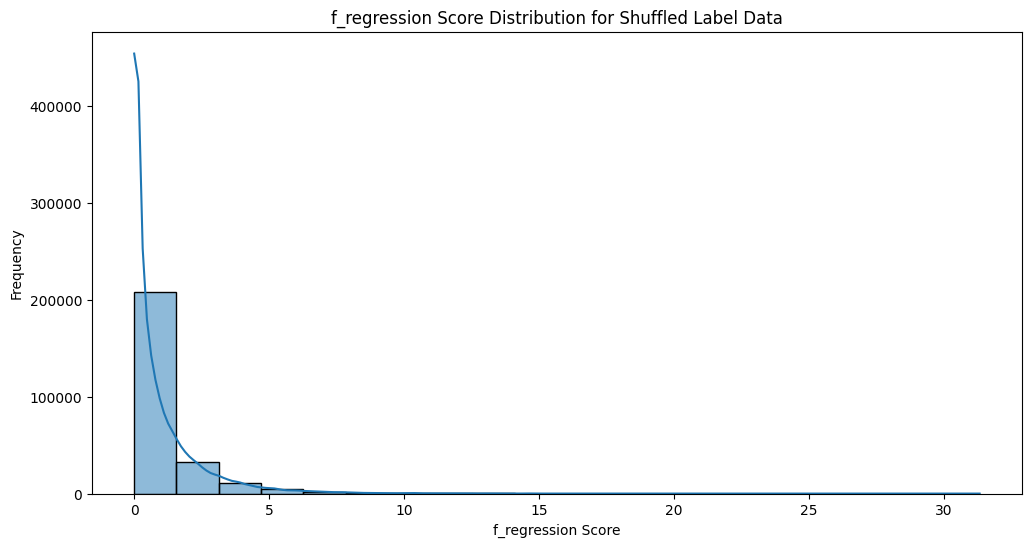

<Figure size 640x480 with 0 Axes>

In [10]:
method = f_regression_select
method_string = 'f_regression'
method_kwargs = {}
all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, n_jobs=1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')

In [11]:
# take the top 5% of scores as the threshold for feature selection
# remove nan first
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
threshold

3.7952337708838777

In [12]:
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)

invalid value encountered in sqrt


In [13]:
# select features with scores above the threshold
df_above_threshold = df[df['Scores'] > threshold]
df_above_threshold
# save f_df_above_threshold to pkl file 
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

In [ ]:
df_above_threshold.shape

### Pearson Correlation

An input array is constant; the correlation coefficient is not defined.


Finished 1 out of 999
Finished 2 out of 999
Finished 3 out of 999
Finished 4 out of 999
Finished 5 out of 999
Finished 6 out of 999
Finished 7 out of 999
Finished 8 out of 999
Finished 9 out of 999
Finished 10 out of 999
Finished 11 out of 999
Finished 12 out of 999
Finished 13 out of 999
Finished 14 out of 999
Finished 15 out of 999
Finished 16 out of 999
Finished 17 out of 999
Finished 18 out of 999
Finished 19 out of 999
Finished 20 out of 999
Finished 21 out of 999
Finished 22 out of 999
Finished 23 out of 999
Finished 24 out of 999
Finished 25 out of 999
Finished 26 out of 999
Finished 27 out of 999
Finished 28 out of 999
Finished 29 out of 999
Finished 30 out of 999
Finished 31 out of 999
Finished 32 out of 999
Finished 33 out of 999
Finished 34 out of 999
Finished 35 out of 999
Finished 36 out of 999
Finished 37 out of 999
Finished 38 out of 999
Finished 39 out of 999
Finished 40 out of 999
Finished 41 out of 999
Finished 42 out of 999
Finished 43 out of 999
Finished 44 out of 9

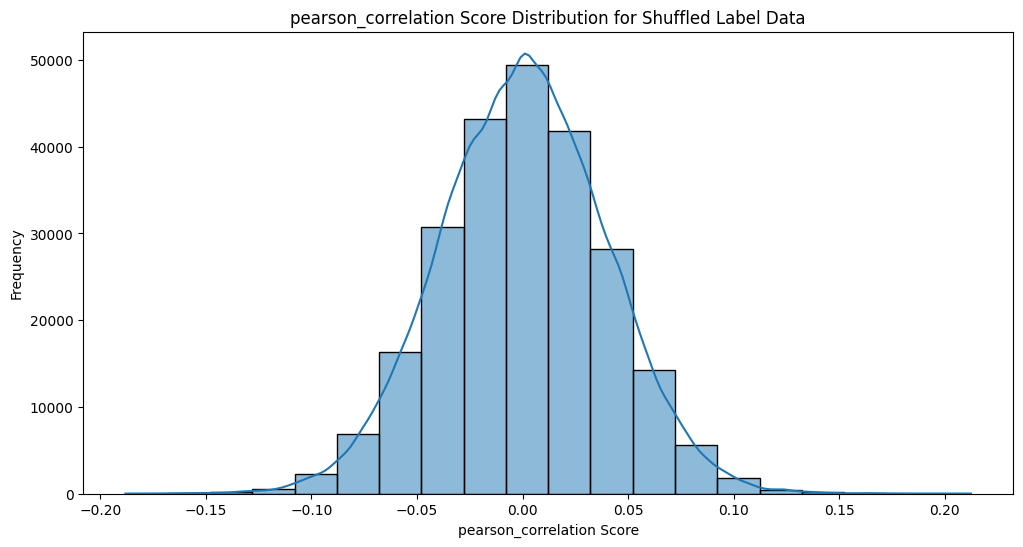

<Figure size 640x480 with 0 Axes>

In [14]:
method = pearson_corr_select
method_string = 'pearson_correlation'
method_kwargs = {'return_all': False}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs)


all_scores = [score for score in all_scores if not np.isnan(score)]
upper_threshold = np.percentile(all_scores, 97.5)
lower_threshold = np.percentile(all_scores, 2.5)
print(upper_threshold, lower_threshold)


# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')

In [15]:
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)

An input array is constant; the correlation coefficient is not defined.


In [16]:
# select features with scores above the threshold
# filter nan values
df = df.dropna()
df_above_threshold = df[df['Scores'] > upper_threshold]
df_below_threshold = df[df['Scores'] < lower_threshold]
# join the two dataframes
df_above_threshold = pd.concat([df_above_threshold, df_below_threshold])

# save f_df_above_threshold to pkl file 
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

In [17]:
df_above_threshold.shape

(39, 2)

### Mutual Information 

Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


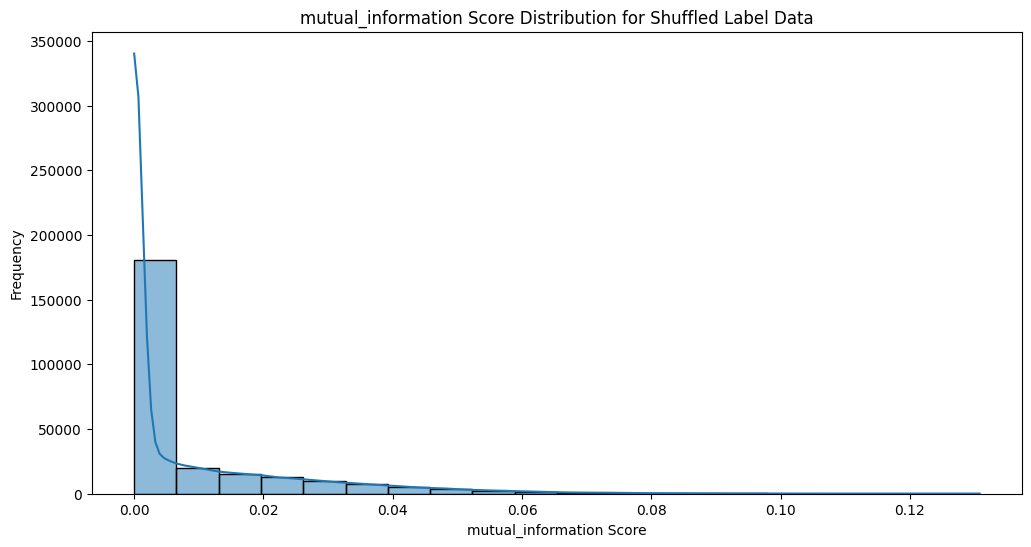

Saved range1000_nml_mutual_information_all_shuffled_label_data.pkl


<Figure size 640x480 with 0 Axes>

In [38]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt
import seaborn as sns

method = mutual_information_select
method_string = 'mutual_information'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, verbose=1, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data:
    # use pickle to save all_scores
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)
    print(f'Saved {exp_id}_{method_string}_all_shuffled_label_data.pkl')

### Relieff

Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


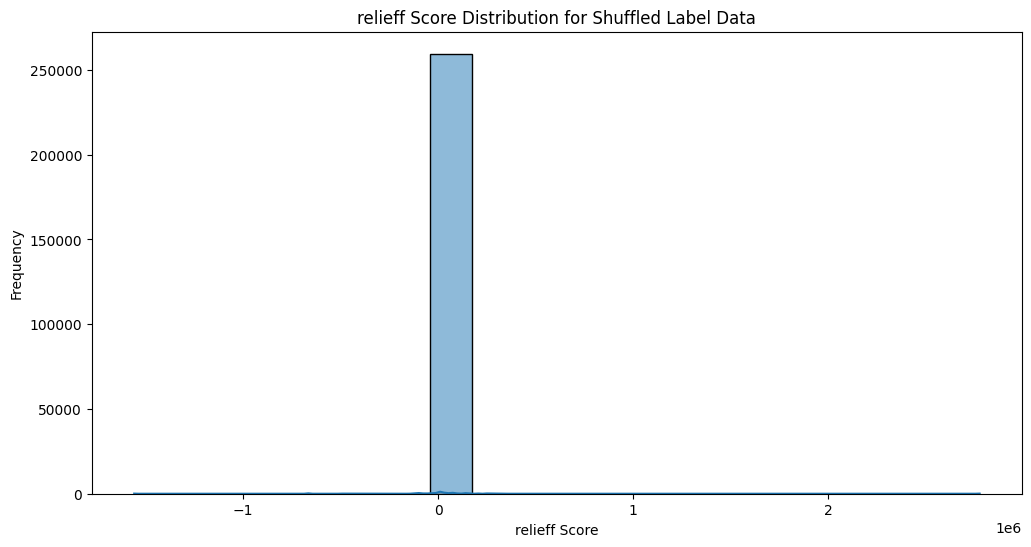

Saved range1000_nml_relieff_all_shuffled_label_data.pkl


<Figure size 640x480 with 0 Axes>

In [14]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

method = relieff_select
method_string = 'relieff'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, verbose=1, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data: 
    # use pickle to save all_scores 
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)
    print(f'Saved {exp_id}_{method_string}_all_shuffled_label_data.pkl')

### Random Forest Embeddings 

Finished 1 out of 25 chunks
Finished 2 out of 25 chunks
Finished 3 out of 25 chunks
Finished 4 out of 25 chunks
Finished 5 out of 25 chunks
Finished 6 out of 25 chunks
Finished 7 out of 25 chunks
Finished 8 out of 25 chunks
Finished 9 out of 25 chunks
Finished 10 out of 25 chunks
Finished 11 out of 25 chunks
Finished 12 out of 25 chunks
Finished 13 out of 25 chunks
Finished 14 out of 25 chunks
Finished 15 out of 25 chunks
Finished 16 out of 25 chunks
Finished 17 out of 25 chunks
Finished 18 out of 25 chunks
Finished 19 out of 25 chunks
Finished 20 out of 25 chunks
Finished 21 out of 25 chunks
Finished 22 out of 25 chunks
Finished 23 out of 25 chunks
Finished 24 out of 25 chunks
Finished 25 out of 25 chunks


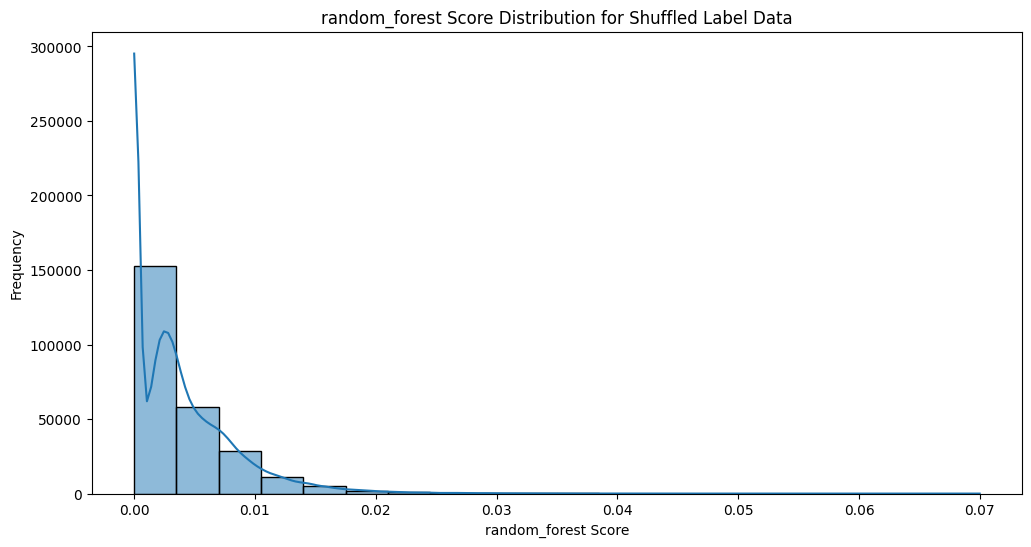

Saved range1000_nml_random_forest_all_shuffled_label_data.pkl


<Figure size 640x480 with 0 Axes>

In [15]:
# do it for all shuffled label data, join the scores and plot histogram distribution of scores 

import matplotlib.pyplot as plt
import seaborn as sns

method = rf_select
method_string = 'random_forest'
method_kwargs = {}

all_scores = get_shuffled_scores(shuffled_label_data, feature_data, method, method_kwargs, n_jobs=-1)

# set plot size
plt.figure(figsize=(12, 6))
sns.histplot(all_scores, bins=20, kde=True)
plt.xlabel(f'{method_string} Score')
plt.ylabel('Frequency')
plt.title(f'{method_string} Score Distribution for Shuffled Label Data')
if show_figure: plt.show()
if save_figure: plt.savefig(f'{file_save_path}{exp_id}_{method_string}_shuffled_label_data.png')
if save_data: 
    # use pickle to save all_scores 
    with open(f'{file_save_path}{exp_id}_{method_string}_all_shuffled_label_data.pkl', 'wb') as f:
        pickle.dump(all_scores, f)
    print(f'Saved {exp_id}_{method_string}_all_shuffled_label_data.pkl')

### Loading Pickled Shuffled Label Data

In [12]:
import pickle 

selection_method_strings = ['mutual_information', 'relieff', 'random_forest']
all_shuffled_label_data = []

for method_str in selection_method_strings:
    with open(f'{file_save_path}{exp_id}_{method_str}_all_shuffled_label_data.pkl', 'rb') as f:
        all_shuffled_label_data.append(pickle.load(f))

In [13]:
## Mutual information 
thresholds = []
all_scores = all_shuffled_label_data[0]
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
thresholds.append(threshold)
threshold

0.04088202356902659

In [102]:
method = mutual_information_select
method_string = 'mutual_information'
method_kwargs = {}
 
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)
# select features with scores above the threshold
df_above_threshold = df[df['Scores'] > threshold]
df_above_threshold

,Selected,Scores
FOXO_min,FOXO_min,0.098550
FOXO_tsv,FOXO_tsv,0.096417
FOXO_init,FOXO_init,0.070657
FOXO_auc,FOXO_auc,0.070053
aShp2_tfc,aShp2_tfc,0.069996
aRas_tfc,aRas_tfc,0.068776
PTP_tfc,PTP_tfc,0.067854
PIP3_init,PIP3_init,0.064249
PIP3_max,PIP3_max,0.064249
aGAB1_tfc,aGAB1_tfc,0.063907


In [103]:
df_above_threshold.shape


(38, 2)

In [104]:
# save f_df_above_threshold to pkl file
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

In [14]:
# Relieff

all_scores = all_shuffled_label_data[1]
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
thresholds.append(threshold)
threshold

13.685458855900642

In [15]:
method = relieff_select
method_string = 'relieff'
method_kwargs = {}
 
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)
# select features with scores above the threshold
df_above_threshold = df[df['Scores'] > threshold]
df_above_threshold

,Selected,Scores
aGAB2_tfc,192,151.484402
pIGFR_init,19,90.635626
pIGFR_max,14,90.635626
pERK_max,174,61.138249
pERK_init,179,61.138249
pFGFR4_min,26,52.577218
pFGFR4_init,29,52.577218
aGAB1_tfc,182,28.759286
pFGFR4_auc,20,26.927659
aShp2_tfc,132,25.869421


In [16]:
df_above_threshold.shape

(21, 2)

In [17]:
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')


In [18]:
all_scores = all_shuffled_label_data[2]
all_scores = [score for score in all_scores if not np.isnan(score)]
threshold = np.percentile(all_scores, 95)
thresholds.append(threshold)
threshold

0.012278332732406728

In [19]:
method = rf_select
method_string = 'random_forest'
method_kwargs = {'random_state': 42}    
 
selected, scores = method(feature_data, label_data, feature_size, **method_kwargs)
df = build_dataframe(selected, scores, feature_data)
# select features with scores above the threshold
df_above_threshold = df[df['Scores'] > threshold]
df_above_threshold

,Selected,Scores
pFRS2_tfc,72,0.032156
aCbl_tfc,232,0.031272
aPDK1_ttsv,97,0.023051
aGAB2_tfc,192,0.021686
pMEK_tsv,168,0.017384
pFRS2_init,79,0.016986
pMEK_auc,160,0.016405
pFRS2_min,76,0.016205
amTORC2_tfc,252,0.015233
PIP3_tsv,68,0.013707


In [20]:
df_above_threshold.shape

(15, 2)

In [21]:
if save_data: df_above_threshold.to_pickle(f'{file_save_path}{exp_id}_{method_string}_above_threshold.pkl')

### Union of all methods

In [18]:
# load from pkl file
methods = ['f_regression', 'pearson_correlation', 'mutual_information', 'relieff', 'random_forest']
df_above_threshold_list = []
for method in methods:
    df_above_threshold = pd.read_pickle(f'{file_save_path}{exp_id}_{method}_above_threshold.pkl')
    df_above_threshold_list.append(df_above_threshold)

union_labels = []
for df in df_above_threshold_list:
    union_labels.extend(df.index.tolist())

# find out which labels are duplicated
from collections import Counter
label_counts = Counter(union_labels)
duplicated_labels = [label for label, count in label_counts.items() if count > 1]
print(duplicated_labels)
unique_labels = [label for label, count in label_counts.items() if count == 1]
print(unique_labels)

union_labels = list(set(union_labels))
len(union_labels)

['amTORC2_tfc', 'aGAB1_max', 'aGAB1_tsv', 'aShp2_max', 'aShp2_tsv', 'aShp2_auc', 'aShp2_median', 'aGAB1_median', 'aGAB1_auc', 'aShp2_min', 'FOXO_tmax', 'aShp2_init', 'FOXO_tmin', 'FOXO_max', 'aGAB1_min', 'FOXO_init', 'aRas_min', 'aShp2_tfc', 'aGrb2_tfc', 'aRas_tfc', 'aGAB1_tfc', 'FOXO_tfc', 'aGAB1_init', 'aRas_auc', 'aPI3K_tfc', 'pIRS_tfc', 'aPDK1_tfc', 'amTORC1_tfc', 'aRas_median', 'aRas_max', 'aRas_tsv', 'aRas_init', 'PIP3_tsv', 'pS6K_init', 'amTORC2_median', 'amTORC2_init', 'amTORC2_min', 'amTORC2_auc', 'amTORC2_max', 'pS6K_tfc', 'FOXO_tsv', 'aSos_min', 'pFGFR4_tfc', 'pFGFR4_min', 'pFGFR4_init', 'SPRY2_tfc', 'aGAB2_tfc']
['pS6K_min', 'PIP3_ttsv', 'FOXO_min', 'FOXO_auc', 'PTP_tfc', 'PIP3_init', 'PIP3_max', 'pSPRY2_min', 'pMEK_init', 'pMEK_max', 'aRaf_auc', 'aPDK1_min', 'pERK_median', 'aPDK1_init', 'PTP_median', 'FOXO_median', 'amTORC1_ttsv', 'PIP3_median', 'pAkt_auc', 'amTORC1_min', 'PIP3_min', 'pERBB_init', 'pIGFR_init', 'pIGFR_max', 'pERK_max', 'pERK_init', 'pFGFR4_auc', 'SPRY2_max

88